### Noise

In [1]:
import torch
import numpy as np
from tqdm import tqdm


from cellot.train.utils import get_free_gpu
replica_id = int(get_free_gpu())
device = torch.device(f'cuda:{replica_id}')
from cellot.models.cond_score_module import Pred_X_0_Parameterization
from cellot.data.utils import *

/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
Using GPUs: 3


2023-08-17 18:23:15,423 Created a temporary directory at /tmp/tmp9r3g6g7f
2023-08-17 18:23:15,427 Writing /tmp/tmp9r3g6g7f/_remote_module_non_scriptable.py


In [2]:
import wandb
run = wandb.init()
artifact = run.use_artifact('protein-optimization/sc_diff/model-ce1o3uhh:v20', type='model')
artifact_dir = artifact.download()

2023-08-17 18:23:16,026 Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnyang (protein-optimization). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [3]:
artifact_dir

'./artifacts/model-ce1o3uhh:v20'

In [4]:
ckpt_path = f'{artifact_dir}/model.ckpt'

In [5]:
import hydra
with hydra.initialize('../configs/diff/'):
    config = hydra.compose(config_name='pred_x_0.yaml')

/tmp/ipykernel_439839/1750149385.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize('../configs/diff/'):


/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'pred_x_0.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


### Noise

In [6]:
config.score_network.n_layers = 2

In [14]:
config.TARGET = 'triamcinolone_acetonide'

In [15]:
lm = Pred_X_0_Parameterization.load_from_checkpoint(hparams=config, checkpoint_path=ckpt_path).to(device)
print('')

Dropout is 0.1



In [16]:
# %%
import cellot.models
from cellot.data.cell import load_cell_data
import torch
from cellot.models.ae import AutoEncoder
from pathlib import Path

def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, device, restore=None, **kwargs):
    # def load_autoencoder_model(config, restore=None, **kwargs):
    
    def load_optimizer(config, params):
        kwargs = dict(config.get("optim", {}))
        assert kwargs.pop("optimizer", "Adam") == "Adam"
        optim = torch.optim.Adam(params, **kwargs)
        return optim


    def load_networks(config, **kwargs):
        kwargs = kwargs.copy()
        kwargs.update(dict(config.get("ae", {})))
        name = kwargs.pop("name")

        # if name == "scgen":
        model = AutoEncoder

        # elif name == "cae":
        #     model = ConditionalAutoEncoder
        # else:
        #     raise ValueError

        return model(**kwargs)
    
    model = load_networks(config, **kwargs)
    optim = load_optimizer(config, model.parameters())

    if restore is not None and Path(restore).exists():
        print('Loading model from checkpoint')
        ckpt = torch.load(restore, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optim.load_state_dict(ckpt["optim_state"])
        # if config.model.name == "scgen" and "code_means" in ckpt:
        #     model.code_means = ckpt["code_means"]
            
    # logger.info(f'Model on device {next(model.parameters()).device}')

    return model, optim

def load(config, device, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, device, restore=restore, **model_kwargs)

    return model, opt, loader
# %% [markdown]
# ### Training

# %%
# restore_path = '/Mounts/rbg-storage1/users/johnyang/cellot/saved_weights/ae/ae.pt'
# ae, _ = load_model(config, 'cuda', restore=restore_path, input_dim=1000)
# autoencoder = ae.to(device)

In [315]:
import numpy as np
from scipy.special import gamma
import torch


class LatentDiffuser:
    """VP-SDE diffuser class for translations."""

    def __init__(self, conf):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self._conf = conf
        self.min_b = conf.min_b
        self.max_b = conf.max_b
        self.schedule = conf.schedule
        self._score_scaling = conf.score_scaling
        self.latent_dim = conf.latent_dim

    def _scale(self, x):
        return x * self._conf.coordinate_scaling

    def _unscale(self, x):
        return x / self._conf.coordinate_scaling

    def b_t(self, t):
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'linear': 
            return self.min_b + t*(self.max_b - self.min_b)
        elif self.schedule == 'cosine':
            return self.max_b + 0.5*(self.min_b - self.max_b)*(1 + np.cos(t*np.pi))
        elif self.schedule == 'exponential':
            sigma = t * np.log10(self.max_b) + (1 - t) * np.log10(self.min_b)
            return 10 ** sigma
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')
    
    def diffusion_coef(self, t):
        """Time-dependent diffusion coefficient."""
        return np.sqrt(self.b_t(t))

    def drift_coef(self, x, t):
        """Time-dependent drift coefficient."""
        return -1/2 * self.b_t(t) * x

    def sample_ref(self, n_samples: float=1):
        return np.random.normal(size=(n_samples, self.latent_dim))

    def marginal_b_t(self, t, use_torch=False, device='cpu'):
        def inner():
            if self.schedule == 'linear':
                return t*self.min_b + (1/2)*(t**2)*(self.max_b-self.min_b)
            elif self.schedule == 'exponential': 
                return (self.max_b**t * self.min_b**(1-t) - self.min_b) / (
                    np.log(self.max_b) - np.log(self.min_b))
            else:
                raise ValueError(f'Unknown schedule {self.schedule}')
        return inner() if not use_torch else torch.tensor(inner()).to(device)

    def calc_trans_0(self, score_t, x_t, t, use_torch=True):
        beta_t = self.marginal_b_t(t)
        beta_t = beta_t[..., None, None]
        exp_fn = torch.exp if use_torch else np.exp
        cond_var = 1 - exp_fn(-beta_t)
        return (score_t * cond_var + x_t) / exp_fn(-1/2*beta_t)

    def forward(self, x_t_1: np.ndarray, t: float, num_t: int):
        """Samples marginal p(x(t) | x(t-1)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t_1 = self._scale(x_t_1)
        b_t = torch.tensor(self.marginal_b_t(t) / num_t).to(x_t_1.device)
        z_t_1 = torch.tensor(np.random.normal(size=x_t_1.shape)).to(x_t_1.device)
        x_t = torch.sqrt(1 - b_t) * x_t_1 + torch.sqrt(b_t) * z_t_1
        return x_t
    
    def distribution(self, x_t, score_t, t, mask, dt):
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        std = g_t * np.sqrt(dt)
        mu = x_t - (f_t - g_t**2 * score_t) * dt
        if mask is not None:
            mu *= mask[..., None]
        return mu, std

    def forward_marginal(self, x_0: np.ndarray, t: float):
        """Samples marginal p(x(t) | x(0)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_0 = self._scale(x_0)
        x_t = np.random.normal(
            loc=np.exp(-1/2*self.marginal_b_t(t)) * x_0,
            scale=np.sqrt(1 - np.exp(-self.marginal_b_t(t)))
        )
        score_t = self.score(x_t, x_0, t)
        x_t = self._unscale(x_t)
        return x_t, score_t

    def score_scaling(self, t: float):
        if self._score_scaling == 'var':
            return 1 / self.conditional_var(t)
        elif self._score_scaling == 'std':
            return 1 / np.sqrt(self.conditional_var(t))
        elif self._score_scaling == 'expected_norm':
            return np.sqrt(2) / (gamma(1.5) * np.sqrt(self.conditional_var(t)))
        else:
            raise ValueError(f'Unrecognized scaling {self._score_scaling}')

    def ode(self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            noise_scale: float=1.0,
        ):
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)

        # Probability flow ODE
        perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        
        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        
        # For positive dt, we add dx and vv.
        x_t_1 = x_t + perturb
        x_t_1 = self._unscale(x_t_1)
        return x_t_1

    def reverse(
            self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            center: bool=True,
            ode: bool=False,
            noise_scale: float=1.0,
        ):
        """Simulates the reverse SDE for 1 step

        Args:
            x_t: [..., 3] current positions at time t in angstroms.
            score_t: [..., 3] rotation score at time t.
            t: continuous time in [0, 1].
            dt: continuous step size in [0, 1].
            mask: True indicates which residues to diffuse.

        Returns:
            [..., 3] positions at next step t-1.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        if ode:
            # Probability flow ODE
            perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        else:
            # Usual stochastic dynamics
            z = noise_scale * np.random.normal(size=score_t.shape)
            perturb = (f_t - g_t**2 * score_t) * dt + g_t * np.sqrt(np.abs(dt)) * z

        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        x_t_1 = x_t - perturb
        if center:
            com = np.sum(x_t_1, axis=-2) / np.sum(mask, axis=-1)[..., None]
            x_t_1 -= com[..., None, :]
        x_t_1 = self._unscale(x_t_1)
        return x_t_1

    def conditional_var(self, t, use_torch=False):
        """Conditional variance of p(xt|x0).

        Var[x_t|x_0] = conditional_var(t)*I

        """
        if use_torch:
            return 1 - torch.exp(-self.marginal_b_t(t, use_torch=use_torch))
        return 1 - np.exp(-self.marginal_b_t(t))

    def score(self, x_t, x_0, t, use_torch=False, scale=False):
        if use_torch:
            exp_fn = torch.exp
        else:
            exp_fn = np.exp
        if scale:
            x_t = self._scale(x_t)
            x_0 = self._scale(x_0)
        
        if use_torch:
            device = x_t.device
            return -(x_t - exp_fn(-1/2*self.marginal_b_t(t, use_torch=True).to(device)) * x_0) / self.conditional_var(t, use_torch=True)
        else:
            return -(x_t - exp_fn(-1/2*self.marginal_b_t(t)) * x_0) / self.conditional_var(t)


In [19]:
from imp import reload
reload(cellot.utils.dev_utils)

<module 'cellot.utils.dev_utils' from '/Mounts/rbg-storage1/users/johnyang/cellot/cellot/utils/dev_utils.py'>

In [20]:
from cellot.utils.dev_utils import load_markers

sel_mg, gene_idxs = load_markers(config)
sel_mg

2023-08-17 18:24:40,238 Loaded cell data with TARGET triamcinolone_acetonide and OBS SHAPE (21528, 16)


Index(['ENSG00000112541.13', 'ENSG00000019186.9', 'ENSG00000154529.14',
       'ENSG00000065809.13', 'ENSG00000144057.15', 'ENSG00000157168.18',
       'ENSG00000215182.8', 'ENSG00000018236.14', 'ENSG00000275395.5',
       'ENSG00000171408.13', 'ENSG00000146674.14', 'ENSG00000116711.9',
       'ENSG00000115414.18', 'ENSG00000145819.15', 'ENSG00000241388.4',
       'ENSG00000023171.16', 'ENSG00000165376.10', 'ENSG00000168955.3',
       'ENSG00000198074.9', 'ENSG00000147408.14', 'ENSG00000125772.12',
       'ENSG00000117983.17', 'ENSG00000117020.16', 'ENSG00000138696.10',
       'ENSG00000185477.4', 'ENSG00000167281.18', 'ENSG00000153162.8',
       'ENSG00000118407.14', 'ENSG00000074410.13', 'ENSG00000184588.17',
       'ENSG00000164330.16', 'ENSG00000038427.15', 'ENSG00000153956.15',
       'ENSG00000181634.7', 'ENSG00000166206.14', 'ENSG00000073756.11',
       'ENSG00000129422.14', 'ENSG00000107957.16', 'ENSG00000180287.16',
       'ENSG00000162687.16', 'ENSG00000106366.8', 'ENSG000000

In [21]:
def DEV_load_ae_cell_data(
        config,
        data=None,
        split_on=None,
        return_as="loader",
        include_model_kwargs=False,
        pair_batch_on=None,
        ae=None,
        encode_latents=False,
        sel_mg=None,
        **kwargs
    ):
        assert ae is not None or not encode_latents, "ae must be provided"
        
        if isinstance(return_as, str):
            return_as = [return_as]

        assert set(return_as).issubset({"anndata", "dataset", "loader"})
        config.data.condition = config.data.get("condition", "drug")
        condition = config.data.condition
        
        data = read_single_anndata(config, **kwargs)
        
        inputs = torch.Tensor(
            data.X if not sparse.issparse(data.X) else data.X.todense()
        )

        if encode_latents:
            genes = data.var_names.to_list()
            data = anndata.AnnData(
                ae.eval().encode(inputs).detach().numpy(),
                obs=data.obs.copy(),
                uns=data.uns.copy(),
            )
            data.uns["genes"] = genes


        # cast to dense and check for nans
        if sparse.issparse(data.X):
            data.X = data.X.todense()
        assert not np.isnan(data.X).any()

        if sel_mg is not None:
            data = data[:, sel_mg]

        dataset_args = dict()
        model_kwargs = {}

        model_kwargs["input_dim"] = data.n_vars

        # if config.get("model.name") == "cae":
        condition_labels = sorted(data.obs[condition].cat.categories)
        model_kwargs["conditions"] = condition_labels
        dataset_args["obs"] = condition
        dataset_args["categories"] = condition_labels

        if "training" in config:
            pair_batch_on = config.training.get("pair_batch_on", pair_batch_on)

        # if split_on is None:
            # if config.model.name == "cellot":
            #     # datasets & dataloaders accessed as loader.train.source
        split_on = ["split", "transport"]
        if pair_batch_on is not None:
            split_on.append(pair_batch_on)

            # if (config.ae.name == "scgen" #or config.ae.name == "cae"
            #     #or config.ae.name == "popalign"):
            # split_on = ["split"]

            # else:
            #     raise ValueError

        if isinstance(split_on, str):
            split_on = [split_on]

        for key in split_on:
            assert key in data.obs.columns

        if len(split_on) > 0:
            splits = {
                (key if isinstance(key, str) else ".".join(key)): data[index]
                for key, index in data.obs[split_on].groupby(split_on).groups.items()
            }

            dataset = nest_dict(
                {
                    key: AnnDataDataset(val.copy(), **dataset_args)
                    for key, val in splits.items()
                },
                as_dot_dict=True,
            )
        else:
            dataset = AnnDataDataset(data.copy(), **dataset_args)

        if "loader" in return_as:
            kwargs = dict(config.dataloader)
            kwargs.setdefault("drop_last", True)
            loader = cast_dataset_to_loader(dataset, **kwargs)

        returns = list()
        for key in return_as:
            if key == "anndata":
                returns.append(data)

            elif key == "dataset":
                returns.append(dataset)

            elif key == "loader":
                returns.append(loader)

        if include_model_kwargs:
            returns.append(model_kwargs)

        if len(returns) == 1:
            return returns[0]

        # returns.append(data)

        return tuple(returns)

In [22]:
data = read_single_anndata(config)
adata = data

In [23]:
# assuming your anndata object is named 'adata'
cell_types = adata.obs['cell_type'].unique() # get unique cell types
cell_type_data = {} # dictionary to store data for each cell type
for ct in cell_types:
    cell_type_data[ct] = adata[adata.obs['cell_type'] == ct]

In [24]:
mcf7 = cell_type_data['MCF7']
a549 = cell_type_data['A549']
k562 = cell_type_data['K562']

In [25]:
a549

View of AnnData object with n_obs × n_vars = 6756 × 1000
    obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes', 'transport', 'split'
    var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score'

In [27]:
a549.obs['drug']

A01_E09_RT_BC_101_Lig_BC_109                    control
A01_E09_RT_BC_110_Lig_BC_19                     control
A01_E09_RT_BC_118_Lig_BC_305                    control
A01_E09_RT_BC_125_Lig_BC_370                    control
A01_E09_RT_BC_128_Lig_BC_154    triamcinolone_acetonide
                                         ...           
H12_F10_RT_BC_83_Lig_BC_61                      control
H12_F10_RT_BC_86_Lig_BC_280                     control
H12_F10_RT_BC_87_Lig_BC_316                     control
H12_F10_RT_BC_91_Lig_BC_56                      control
H12_F10_RT_BC_92_Lig_BC_271                     control
Name: drug, Length: 6756, dtype: category
Categories (2, object): ['triamcinolone_acetonide', 'control']

/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


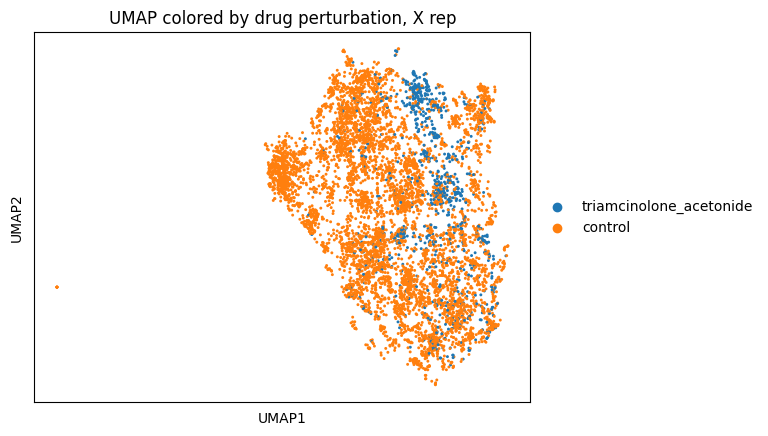

In [89]:
sc.pp.neighbors(a549, n_neighbors=3, use_rep='X')

# Recalculate UMAP with adjusted hyperparameters
sc.tl.umap(a549, min_dist=0.1)

# Plot UMAP
sc.pl.umap(a549, color='drug', title='UMAP colored by drug perturbation, X rep')

In [49]:
a549

AnnData object with n_obs × n_vars = 6756 × 1000
    obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes', 'transport', 'split'
    var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'rank_genes_groups', 'neighbors', 'umap', 'drug_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score'
    obsp: 'distances', 'connectivities'

In [55]:
a549.var['gene_short_name']

1

In [63]:
gene_name = 'ANGPTL4'
# First, let's check if the gene_name exists in the dataset
if gene_name in adata.var['gene_short_name'].values:

    # Get the row index of the gene expression matrix
    row_index = adata.var.index.get_loc(adata.var[adata.var['gene_short_name'] == gene_name].index[0])
    
    # Get the value of X for the specified gene and cell
    x_value = adata.X[:, row_index]
    
    print(f"The values of X for gene {gene_name} in is {x_value}")
    
else:
    print(f"Gene {gene_name} not found in the dataset.")


The values of X for gene ANGPTL4 in is   (7, 0)	1.3986454
  (14, 0)	0.6143162
  (18, 0)	2.5359092
  (39, 0)	2.5402029
  (58, 0)	2.879576
  (202, 0)	1.4986947
  (222, 0)	2.3149176
  (226, 0)	3.0247393
  (233, 0)	2.762336
  (293, 0)	1.7485186
  (352, 0)	2.4398398
  (421, 0)	0.87147486
  (640, 0)	0.6399461
  (658, 0)	1.654434
  (659, 0)	0.4829495
  (664, 0)	0.77618146
  (688, 0)	2.129766
  (744, 0)	1.7698095
  (772, 0)	1.0314229
  (814, 0)	1.5181538
  (853, 0)	1.5530331
  (874, 0)	0.96860003
  (939, 0)	2.1021698
  (944, 0)	2.7123542
  (964, 0)	0.9761658
  :	:
  (20842, 0)	2.311635
  (20857, 0)	0.5836918
  (20881, 0)	2.6178687
  (20883, 0)	1.6435732
  (20892, 0)	2.2321055
  (20911, 0)	2.968907
  (20916, 0)	2.193677
  (20929, 0)	1.813868
  (20940, 0)	1.4365492
  (20948, 0)	1.2973468
  (21005, 0)	2.3083653
  (21117, 0)	0.5215579
  (21125, 0)	0.49645084
  (21141, 0)	1.6412203
  (21143, 0)	1.4311959
  (21186, 0)	0.6456762
  (21201, 0)	2.2276616
  (21203, 0)	1.9967895
  (21250, 0)	2.014037
  (2

Control: 96.04% cells with zero expression, 3.96% cells with non-zero expression
Triamcinolone Acetonide: 81.26% cells with zero expression, 18.74% cells with non-zero expression


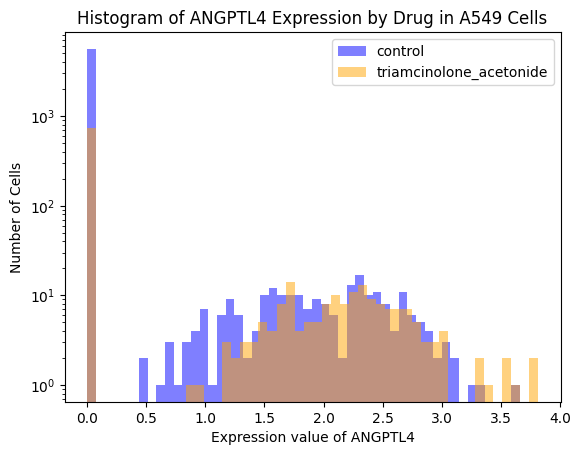

In [95]:
import matplotlib.pyplot as plt
import numpy as np

gene_name = 'ANGPTL4'

def plot_gene_hist(gene_name, adata):
    # First, let's check if the gene_name exists in the dataset
    if gene_name in adata.var['gene_short_name'].values:

        # Get the row index of the gene expression matrix
        row_index = adata.var.index.get_loc(adata.var[adata.var['gene_short_name'] == gene_name].index[0])
        
        # Get the expression values of the specified gene across all cells
        x_value = adata.X[:, row_index].toarray().flatten() if hasattr(adata.X, "toarray") else adata.X[:, row_index]
        
        # Mask for control and triamcinolone_acetonide
        control_mask = adata.obs['drug'] == 'control'
        triamcinolone_mask = adata.obs['drug'] == 'triamcinolone_acetonide'
        
        # Calculate percentages for control
        control_zero_percent = np.mean(x_value[control_mask] == 0) * 100
        control_nonzero_percent = 100 - control_zero_percent

        # Calculate percentages for triamcinolone_acetonide
        triamcinolone_zero_percent = np.mean(x_value[triamcinolone_mask] == 0) * 100
        triamcinolone_nonzero_percent = 100 - triamcinolone_zero_percent

        print(f"Control: {control_zero_percent:.2f}% cells with zero expression, {control_nonzero_percent:.2f}% cells with non-zero expression")
        print(f"Triamcinolone Acetonide: {triamcinolone_zero_percent:.2f}% cells with zero expression, {triamcinolone_nonzero_percent:.2f}% cells with non-zero expression")


        # Plot histogram for control and triamcinolone_acetonide
        plt.hist(x_value[control_mask], bins=50, alpha=0.5, label='control', color='blue')
        plt.hist(x_value[triamcinolone_mask], bins=50, alpha=0.5, label='triamcinolone_acetonide', color='orange')

        plt.xlabel(f'Expression value of {gene_name}')
        plt.ylabel('Number of Cells')
        plt.yscale('log')  # Set the y-axis to log scale

        plt.title(f'Histogram of {gene_name} Expression by Drug in A549 Cells')
        plt.legend()
        plt.show()

    else:
        print(f"Gene {gene_name} not found in the dataset.")
    
plot_gene_hist(gene_name, a549)


In [81]:
for x in sorted(adata.var['gene_short_name'].value_counts().keys()):
    print(x)

ABCA8
ABCB1
ABCC2
ABCC3
ABCC4
ABO
AC002472.2
AC002480.1
AC002480.4
AC002546.2
AC004687.1
AC004704.1
AC004870.4
AC004917.1
AC004990.1
AC005208.1
AC005307.1
AC005394.2
AC005537.1
AC006369.1
AC006387.1
AC007319.1
AC007384.1
AC007402.1
AC008050.1
AC008105.3
AC008415.1
AC008736.1
AC008825.1
AC008957.1
AC009133.1
AC009264.1
AC009271.1
AC010197.1
AC010343.3
AC010601.1
AC010894.3
AC011247.1
AC011287.1
AC011476.3
AC011498.4
AC011632.1
AC015574.1
AC016687.3
AC016723.1
AC016831.1
AC016876.1
AC020687.1
AC022523.1
AC022568.1
AC024084.1
AC024267.1
AC024909.1
AC025419.1
AC025524.2
AC068051.1
AC068533.2
AC068633.1
AC069185.1
AC069277.1
AC073365.1
AC073896.4
AC078845.1
AC078883.1
AC078923.1
AC078993.1
AC079160.1
AC079466.1
AC079801.1
AC084033.3
AC087235.1
AC087280.2
AC087633.2
AC087857.1
AC090358.1
AC090630.1
AC090809.1
AC091489.1
AC091976.1
AC092650.1
AC092957.1
AC093001.1
AC093110.1
AC093607.1
AC093772.1
AC096711.3
AC097374.1
AC097478.1
AC097512.1
AC098613.1
AC098617.1
AC099489.1
AC099520.1
AC103702.

In [78]:
datasets = DEV_load_ae_cell_data(config, return_as='dataset')#, ae=autoencoder.cpu(), encode_latents=True)#, sel_mg=sel_mg)

In [90]:
datasets

{'test': {'source': <cellot.data.utils.AnnDataDataset at 0x7f0b8787d3d0>,
  'target': <cellot.data.utils.AnnDataDataset at 0x7f0b878fc5e0>},
 'train': {'source': <cellot.data.utils.AnnDataDataset at 0x7f0b878a2d60>,
  'target': <cellot.data.utils.AnnDataDataset at 0x7f0994235ca0>}}

In [109]:
def cells_with_zero_expression(gene_name, adata):
    # Check if the gene_name exists in the dataset
    if gene_name in adata.var['gene_short_name'].values:

        # Get the row index of the gene expression matrix
        row_index = adata.var.index.get_loc(adata.var[adata.var['gene_short_name'] == gene_name].index[0])
        
        # Get the expression values of the specified gene across all cells
        x_value = adata.X[:, row_index].toarray().flatten() if hasattr(adata.X, "toarray") else adata.X[:, row_index]

        # Filter cells by drug condition
        control_mask = (adata.obs['drug'] == 'control') & (x_value == 0)
        triamcinolone_mask = (adata.obs['drug'] == 'triamcinolone_acetonide') & (x_value != 0)

        # Get indices where expression value is 0
        control_zero = adata.obs_names[control_mask]
        tri_non_zero = adata.obs_names[triamcinolone_mask]

        return control_zero, tri_non_zero

    else:
        print(f"Gene {gene_name} not found in the dataset.")
        return None

control_zero, tri_non_zero = cells_with_zero_expression('ANGPTL4', a549)
control_zero, tri_non_zero

(Index(['A01_E09_RT_BC_101_Lig_BC_109', 'A01_E09_RT_BC_110_Lig_BC_19',
        'A01_E09_RT_BC_118_Lig_BC_305', 'A01_E09_RT_BC_125_Lig_BC_370',
        'A01_E09_RT_BC_138_Lig_BC_69', 'A01_E09_RT_BC_146_Lig_BC_370',
        'A01_E09_RT_BC_153_Lig_BC_288', 'A01_E09_RT_BC_161_Lig_BC_192',
        'A01_E09_RT_BC_168_Lig_BC_111', 'A01_E09_RT_BC_186_Lig_BC_69',
        ...
        'H12_F10_RT_BC_5_Lig_BC_165', 'H12_F10_RT_BC_65_Lig_BC_265',
        'H12_F10_RT_BC_71_Lig_BC_16', 'H12_F10_RT_BC_71_Lig_BC_334',
        'H12_F10_RT_BC_73_Lig_BC_147', 'H12_F10_RT_BC_83_Lig_BC_61',
        'H12_F10_RT_BC_86_Lig_BC_280', 'H12_F10_RT_BC_87_Lig_BC_316',
        'H12_F10_RT_BC_91_Lig_BC_56', 'H12_F10_RT_BC_92_Lig_BC_271'],
       dtype='object', length=5622),
 Index(['A01_E09_RT_BC_128_Lig_BC_154', 'A01_E09_RT_BC_156_Lig_BC_26',
        'A01_F10_RT_BC_316_Lig_BC_308', 'A01_F10_RT_BC_374_Lig_BC_334',
        'A02_E09_RT_BC_230_Lig_BC_293', 'A03_F10_RT_BC_361_Lig_BC_356',
        'A04_F10_RT_BC_163_Lig_B

In [107]:
sum(a549.obs['drug'] == 'triamcinolone_acetonide')

902

In [117]:
ex_c_id = control_zero[0]

In [125]:
ex_c = adata[ex_c_id].X.toarray()

In [126]:
ex_c

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 3.3937356, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.      

In [318]:
diffuser = LatentDiffuser(config.diffuser)

In [320]:
from cellot.utils.dev_utils import get_target_cond_idx
import numpy as np

gammas = np.logspace(1, -3, num=50)

def step(lm, x_t, y, t, dt, forward=True, ode=True):
    x_t = torch.tensor(x_t).float().to(device)
    pred_x_0 = lm.score_network((x_t, y), t)
    cond_score = lm.diffuser.score(x_t, pred_x_0, t, use_torch=True)
    x_t = x_t.detach().cpu().numpy()
    cond_score = cond_score.detach().cpu().numpy()
    if ode:
        if forward:
            x_t_out = lm.diffuser.ode(x_t=x_t, score_t=cond_score, t=t, dt=dt)
        else:
            x_t_out = lm.diffuser.ode(x_t=x_t, score_t=cond_score, t=t, dt=-dt)
    else:
        if forward:
            #NOTE: We use the diffuser defined in the notebook here rather than lm's diffuser bc we needed to account for -dt.
            x_t_out = diffuser.reverse(x_t=x_t, score_t=cond_score, t=t, dt=-dt, ode=False, center=False) #need negative dt because we call the reverse method.
        else:
            x_t_out = diffuser.reverse(x_t=x_t, score_t=cond_score, t=t, dt=dt, ode=False, center=False)
    return x_t_out, pred_x_0

def inference(lm, batch, lamb=4, dt=0.01, t_start=1.0, cond=True, ae=None, target=None):
    device = lm.device
    # assert ae is not None, 'Must provide autoencoder'
    assert target is not None or not cond, 'Must provide target'
    
    with torch.inference_mode():
        lm.eval()
        all_genes_x, y_batch = batch
        fwd_y = y_batch.to(device)

        # Forward ODE calculations
        x_t_fwd = all_genes_x
        for fwd_t in np.arange(0 + dt, t_start, dt):
            x_t_fwd, _ = step(lm, x_t_fwd, fwd_y, fwd_t, dt, forward=True, ode=True)
            
        diffuser_code = x_t_fwd.copy()

        # Prepare for reverse calculations
        x_t_rvs = x_t_fwd.copy()
        rvs_y = torch.ones_like(y_batch) * get_target_cond_idx(target) if cond else y_batch
        # print(f'In reverse, Conditioning on {reverse_y}')
        # Reverse ODE calculations
        for rvs_t in np.arange(t_start, 0, -dt):
            x_t_rvs, _ = step(lm, x_t_rvs, rvs_y, rvs_t, dt, forward=False, ode=False)
        
        # Decode final result
        x_0 = torch.tensor(x_t, dtype=torch.float).to(lm.device)
        # recon = ae.eval().decode(x_0)
        return x_0, diffuser_code

In [321]:
ex_c

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 3.3937356, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.      

In [251]:
lm.score_network.null_cond_idx

189

In [252]:
target_cond_idx = get_target_cond_idx(config.TARGET)
control_cond_idx = get_target_cond_idx('control')

In [253]:
control_cond_idx

44

In [254]:
ANGPTL4_row_index = adata.var.index.get_loc(adata.var[adata.var['gene_short_name'] == 'ANGPTL4'].index[0])
ANGPTL4_row_index

767

In [330]:
dt = 0.0001
t_start = 1.0
fwd_idx = control_cond_idx
rvs_idx = target_cond_idx

with torch.inference_mode():
    lm.eval()
    x_t_fwd = ex_c
    # for i in range(num_traj):
        # fwd_y = torch.tensor([lm.score_network.null_cond_idx]).to(device)
        
    fwd_x_0s = []
    rvs_x_0s = []
        
    fwd_y = torch.tensor([fwd_idx]).to(device)
    for fwd_t in np.arange(0 + dt, t_start, dt):
        x_t_fwd, x_0_t = step(lm, x_t_fwd, fwd_y, fwd_t, dt, forward=True, ode=False)
        
        fwd_x_0s.append(x_0_t.detach().cpu().numpy()[ANGPTL4_row_index])
    
    diffuser_code = x_t_fwd.copy()
    x_t_rvs = x_t_fwd.copy()
    
    rvs_y = torch.tensor([rvs_idx]).to(device)
    
    for rvs_t in np.arange(t_start, 0, -dt):
        x_t_rvs, x_0_t = step(lm, x_t_rvs, rvs_y, rvs_t, dt, forward=False, ode=False)
        rvs_x_0s.append(x_0_t.detach().cpu().numpy()[ANGPTL4_row_index])

    

In [331]:
fwd_x_0s

[0.03655861,
 0.051506773,
 0.061718248,
 0.071148574,
 0.0827543,
 0.09357697,
 0.10416241,
 0.11446151,
 0.1245663,
 0.1331162,
 0.14112265,
 0.14899033,
 0.1557942,
 0.16211252,
 0.16897924,
 0.17582902,
 0.18236922,
 0.18970014,
 0.19840103,
 0.20663604,
 0.21351299,
 0.21908784,
 0.22405949,
 0.2284544,
 0.23310353,
 0.23787972,
 0.24286371,
 0.24717298,
 0.25122076,
 0.2555753,
 0.2603463,
 0.26500392,
 0.26923087,
 0.27208397,
 0.27417442,
 0.27764094,
 0.28126553,
 0.28507125,
 0.2888153,
 0.29281327,
 0.29653898,
 0.3002889,
 0.30399045,
 0.30772462,
 0.3109466,
 0.313548,
 0.31624404,
 0.31875873,
 0.32176557,
 0.32510912,
 0.32846168,
 0.331734,
 0.33512077,
 0.3380165,
 0.34080693,
 0.34412915,
 0.34745523,
 0.350539,
 0.35278767,
 0.35485157,
 0.3564181,
 0.3579651,
 0.35969043,
 0.36154824,
 0.3632768,
 0.36487022,
 0.36645797,
 0.36759984,
 0.3691886,
 0.37101552,
 0.37197515,
 0.3730044,
 0.37447652,
 0.3762808,
 0.37802756,
 0.38013834,
 0.381915,
 0.38335228,
 0.38500

In [332]:
rvs_x_0s

[116.7337,
 116.674164,
 116.613304,
 116.55291,
 116.492035,
 116.43169,
 116.37216,
 116.3114,
 116.25127,
 116.19141,
 116.13056,
 116.06978,
 116.00943,
 115.94984,
 115.88861,
 115.82862,
 115.768364,
 115.707504,
 115.64663,
 115.58668,
 115.52655,
 115.465805,
 115.405136,
 115.344666,
 115.28415,
 115.22406,
 115.16435,
 115.104256,
 115.04454,
 114.98409,
 114.92369,
 114.8642,
 114.80434,
 114.74431,
 114.684616,
 114.62514,
 114.56538,
 114.505875,
 114.44557,
 114.38563,
 114.32663,
 114.26629,
 114.207184,
 114.14734,
 114.08728,
 114.02839,
 113.96874,
 113.90872,
 113.849846,
 113.79019,
 113.73115,
 113.6713,
 113.61198,
 113.55324,
 113.49341,
 113.43379,
 113.374794,
 113.31511,
 113.256546,
 113.19808,
 113.13968,
 113.081406,
 113.02281,
 112.964264,
 112.90489,
 112.847176,
 112.78841,
 112.72905,
 112.670395,
 112.6115,
 112.553085,
 112.49448,
 112.434784,
 112.376114,
 112.31754,
 112.26003,
 112.2021,
 112.14401,
 112.08476,
 112.02653,
 111.96833,
 111.90877,


In [333]:
ex_c[:, ANGPTL4_row_index]

array([0.], dtype=float32)

In [334]:
x_t_fwd[:, ANGPTL4_row_index]

array([-15786.20452087])

In [335]:
x_t_rvs[:, ANGPTL4_row_index]

array([0.03017612])

In [228]:
# Define list variables
gts, recons, uncond_recons, d_codes, uncond_d_codes = [], [], [], [], []

loss_list = []

# Function for inference and data gathering
def process_batch(batch):
    batch = [x.to(device) for x in batch]
    gts.append(batch)

    # Conditioned inference
    recon, diffuser_code = inference(
        lm, batch, lamb=4, dt=0.1, t_start=1.0, cond=True, ae=None, target=config.TARGET)

    # Unconditioned inference
    uncond_recon, uncond_d_code = inference(
        lm, batch, ae=None, lamb=4, dt=0.1, t_start=1.0, cond=False, target=config.TARGET)

    # Data gathering
    recons.append(recon.detach().cpu().numpy())
    d_codes.append(diffuser_code)
    uncond_d_codes.append(uncond_d_code)
    uncond_recons.append(uncond_recon.detach().cpu().numpy())
    
# Process batches
# for batch in tqdm(loader.train.source):
#     process_batch(batch)

for batch in tqdm(loader.test.source):
    process_batch(batch)

  0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_439839/92606825.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t = torch.tensor(x_t).float().to(device)
  0%|          | 0/14 [00:00<?, ?it/s]


NameError: name 'score_t' is not defined

In [ ]:
d_codes.__len__()

14

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Convert d_codes list into a numpy array
d_codes_arr = np.concatenate(d_codes, axis=0)

# Extract labels from gts
# labels = torch.cat([item[1] for item in gts], dim=0).cpu().numpy()

# UMAP transformation
reducer = umap.UMAP()
embedding = reducer.fit_transform(d_codes_arr)

# Plotting
plt.figure(figsize=(10,8))

# Create a scatter plot with labels
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral')

# Create a colorbar
cbar = plt.colorbar(scatter)
# cbar.set_label('Labels')

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the d_codes', fontsize=24)
plt.show()

KeyboardInterrupt: 

In [23]:
all_recons = np.concatenate(recons, axis=0)

In [24]:
all_recons.shape

(3513, 1000)

In [25]:
target = datasets.test.target.adata.X
target.shape

(656, 1000)

In [ ]:
def compute_mmd_on_selected_genes(recon, target, selected_genes, gammas):
    return compute_mmd_loss(recon[:, selected_genes], target[:, selected_genes], gammas)

In [26]:
gt_xs = torch.cat([x[0] for x in gts], axis=0).cpu().numpy()

In [27]:
np.mean((all_recons - gt_xs)**2)

4.5430854e-05

In [28]:
mmd_loss = compute_mmd_on_selected_genes(all_recons, target, gene_idxs, gammas)

NameError: name 'compute_mmd_on_selected_genes' is not defined

In [29]:
all_recons

array([[ 2.9415979e+00, -1.2396634e-04,  5.8800081e-04, ...,
        -1.2783051e-04,  2.6787082e-03,  1.3205948e-03],
       [ 3.0650436e-03, -2.5116088e-04, -6.4608699e-05, ...,
         4.1999275e-04,  1.3280982e-04,  1.3620380e-04],
       [-1.9429016e-04, -4.4532906e-05,  5.9531415e-01, ...,
         4.2137521e-04, -4.5977766e-04,  1.1249885e-04],
       ...,
       [ 8.6575898e-04, -1.4801277e-05, -6.0082821e-04, ...,
         1.7668153e-04,  4.0505812e-04,  3.9263713e-04],
       [-3.7391521e-03,  7.0475321e-04, -9.1678865e-04, ...,
        -6.2155852e-04,  2.5850243e-04, -6.4057991e-04],
       [ 2.5734100e-03, -1.8940530e-04,  9.4499520e-04, ...,
         4.5139610e-04,  1.4826648e-03,  3.6352291e-04]], dtype=float32)

In [ ]:
mmd_loss

0.01700967229437083

In [ ]:
tgts = []
for batch in loader.train.target:
    tgts.append(batch[0])

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_marker_gene_expression(all_gts, target, all_recon, all_uncond_recons, gene_idxs, gene_names, cutoff=0.1, font_size=32, fig_title='Top 5 Marker Gene Expression Histograms for Trametinib Perturbation'):
    # Prepare figure and axes
    fig, axs = plt.subplots(len(gene_idxs), 4, figsize=(50, 40))
    plt.rcParams.update({'font.size': font_size})  # Update font size

    for i in range(len(gene_idxs)):
        # Extract values
        source_values = all_gts[:, gene_idxs[i]]
        target_values = target[:, gene_idxs[i]]
        recon_values = all_recon[:, gene_idxs[i]]
        uncond_recon_values = all_uncond_recons[:, gene_idxs[i]]
        # latent_iden_recon_values = all_latent_identities[:, gene_idxs[i]]

        # Create subplots
        axs[i][0].hist(source_values[source_values > cutoff])
        axs[i][0].set_title('Source')
        axs[i][1].hist(target_values[target_values > cutoff])
        axs[i][1].set_title('Target')
        axs[i][2].hist(recon_values[recon_values > cutoff])
        axs[i][2].set_title('Cond Recon')
        axs[i][3].hist(uncond_recon_values[uncond_recon_values > cutoff])
        axs[i][3].set_title('Uncond Recon')
        # axs[i][4].hist(latent_iden_recon_values[latent_iden_recon_values > cutoff])
        # axs[i][4].set_title('Latent Iden Recon')

        axs[i][0].set_ylabel(gene_names[i])

    # Adjust figure and show
    fig.subplots_adjust(top=0.95)  # Adjust as needed
    fig.suptitle(fig_title)
    plt.show()


In [31]:
all_uncond_recons = np.concatenate(uncond_recons, axis=0)

In [34]:
all_recons

array([[ 2.9415979e+00, -1.2396634e-04,  5.8800081e-04, ...,
        -1.2783051e-04,  2.6787082e-03,  1.3205948e-03],
       [ 3.0650436e-03, -2.5116088e-04, -6.4608699e-05, ...,
         4.1999275e-04,  1.3280982e-04,  1.3620380e-04],
       [-1.9429016e-04, -4.4532906e-05,  5.9531415e-01, ...,
         4.2137521e-04, -4.5977766e-04,  1.1249885e-04],
       ...,
       [ 8.6575898e-04, -1.4801277e-05, -6.0082821e-04, ...,
         1.7668153e-04,  4.0505812e-04,  3.9263713e-04],
       [-3.7391521e-03,  7.0475321e-04, -9.1678865e-04, ...,
        -6.2155852e-04,  2.5850243e-04, -6.4057991e-04],
       [ 2.5734100e-03, -1.8940530e-04,  9.4499520e-04, ...,
         4.5139610e-04,  1.4826648e-03,  3.6352291e-04]], dtype=float32)

In [33]:
all_uncond_recons

array([[ 2.94184899e+00, -1.48876774e-04,  6.67648739e-04, ...,
        -1.38680014e-04,  2.40160339e-03,  1.45325740e-03],
       [ 1.12074253e-03, -2.98111787e-04, -5.87617978e-05, ...,
         3.36358382e-04,  1.43614059e-04,  1.20752142e-04],
       [ 1.73816021e-04, -1.21009463e-04,  5.95473707e-01, ...,
         4.01835365e-04, -4.80636081e-04,  1.14469454e-04],
       ...,
       [ 1.31868699e-03, -1.04876788e-04, -3.57754179e-04, ...,
         1.41136479e-04,  3.99812037e-04,  3.83384671e-04],
       [-3.58840358e-03,  5.53545018e-04, -6.48598361e-04, ...,
        -6.62905863e-04,  2.91935867e-04, -7.31510052e-04],
       [ 2.70458939e-03, -1.63485456e-04,  9.93885333e-04, ...,
         3.62377526e-04,  1.25144969e-03,  5.71646728e-04]], dtype=float32)

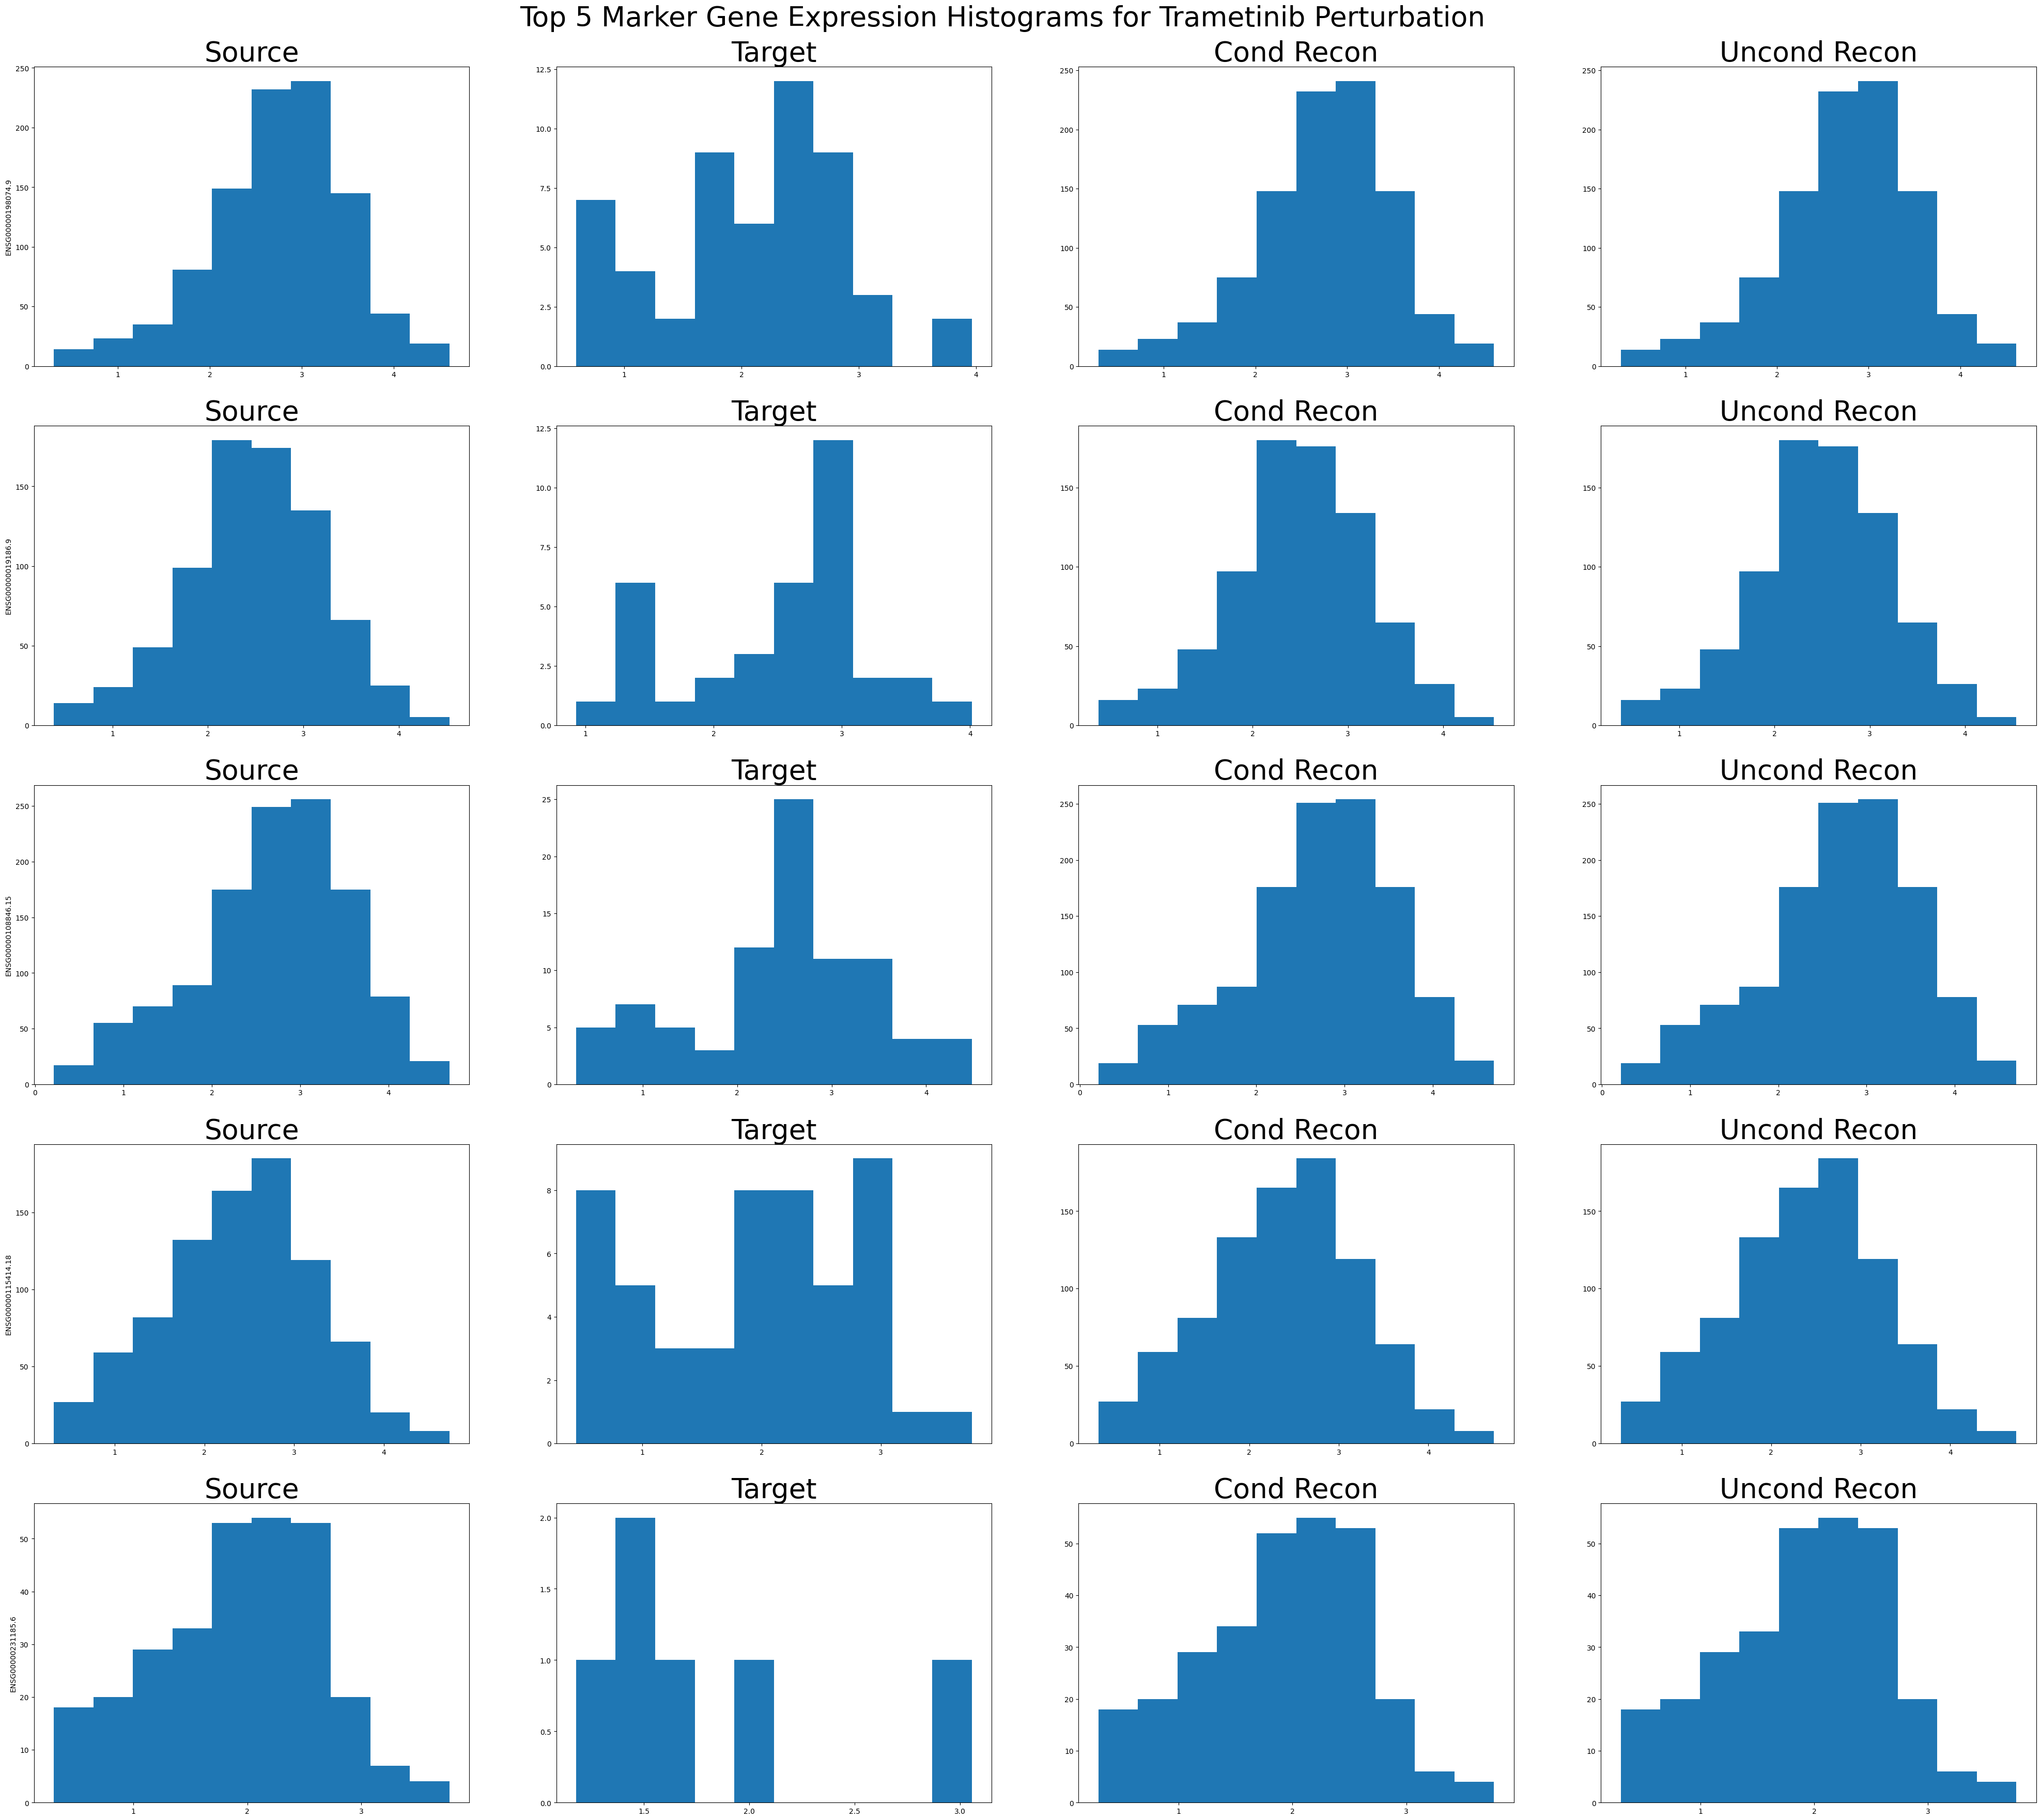

In [32]:
plot_marker_gene_expression(gt_xs, target, all_recons, all_uncond_recons, gene_idxs[:5], sel_mg[:5])

In [ ]:
from cellot import losses
losses.compute_scalar_mmd(all_recon[:, gene_idxs[:50]].detach().cpu().numpy(), sel_target)

0.016602373914793134